Importing Libraries

In [134]:
import geopandas as gpd
import pandas as pd
import numpy as np
from shapely.geometry import Polygon, MultiPolygon, LineString



Loading Datasets

In [135]:

cadastre = gpd.read_file("cadastre.gpkg")
roads = gpd.read_file("roads.gpkg")
gnaf = pd.read_parquet("gnaf_prop.parquet")
transactions = pd.read_parquet("transactions.parquet")

print("Datasets loaded:")
print("Cadastre:", len(cadastre))
print("Roads:", len(roads))
print("GNAF:", len(gnaf))
print("Transactions:", len(transactions))


Datasets loaded:
Cadastre: 1294
Roads: 173
GNAF: 70591
Transactions: 5576


CRS Alignment

In [136]:

roads = roads.to_crs(cadastre.crs)


Find nearest road

In [137]:
print(cadastre.columns)


Index(['state', 'sa4', 'geometry'], dtype='object')


In [138]:

cadastre["centroid"] = cadastre.geometry.centroid

cadastre = cadastre.sjoin_nearest(roads[['geometry']], how='left', distance_col='dist_to_road')

print("Nearest road joined. Columns now:", cadastre.columns)


Nearest road joined. Columns now: Index(['state', 'sa4', 'geometry', 'centroid', 'index_right', 'dist_to_road'], dtype='object')


/tmp/ipython-input-1832273709.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  cadastre["centroid"] = cadastre.geometry.centroid
/usr/local/lib/python3.12/dist-packages/geopandas/array.py:408: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


Determine facing edge

In [139]:

from shapely.geometry import Polygon, MultiPolygon, LineString

def get_facing_edge(polygon, road_geom):

    if polygon is None or road_geom is None:
        return None

    min_dist = float('inf')
    facing_edge = None


    if isinstance(polygon, MultiPolygon):
        polygons = polygon.geoms
    else:
        polygons = [polygon]

    for poly in polygons:
        coords = list(poly.exterior.coords)
        for i in range(len(coords) - 1):
            segment = LineString([coords[i], coords[i + 1]])
            d = segment.distance(road_geom)
            if d < min_dist:
                min_dist = d
                facing_edge = segment

    return facing_edge


def safe_facing_edge(row):
    try:
        road_geom = roads.iloc[int(row['index_right'])].geometry
        return get_facing_edge(row.geometry, road_geom)
    except:
        return None

cadastre['facing_edge'] = cadastre.apply(safe_facing_edge, axis=1)



Calculate azimuth

In [140]:

def get_azimuth(line):
    if line is None:
        return None
    x1, y1 = line.coords[0]
    x2, y2 = line.coords[-1]
    angle = np.degrees(np.arctan2((x2 - x1), (y2 - y1)))
    angle = (angle + 360) % 360
    return angle

cadastre['azimuth'] = cadastre['facing_edge'].apply(get_azimuth)


Convert to Cardinal Orientation

In [141]:

def angle_to_direction(angle):
    if angle is None:
        return None
    dirs = ["N", "NE", "E", "SE", "S", "SW", "W", "NW"]
    idx = int((angle + 22.5) // 45) % 8
    return dirs[idx]

cadastre['orientation'] = cadastre['azimuth'].apply(angle_to_direction)



In [142]:

if 'property_id' in cadastre.columns and 'property_id' in gnaf.columns:
    merged = cadastre.merge(gnaf[['property_id', 'address']], on='property_id', how='left')
else:
    merged = cadastre.copy()
    merged['address'] = gnaf['address'][:len(cadastre)].values




In [143]:

output = merged[['address', 'orientation']]
output.head()
output.to_csv("property_orientation.csv", index=False)
output.head(10)



,address,orientation
0,10 MELNOTTE AVENUE,NW
0,11 MELNOTTE AVENUE,W
1,12 MELNOTTE AVENUE,SE
2,13 MELNOTTE AVENUE,NW
3,14 MELNOTTE AVENUE,SE
4,15 MELNOTTE AVENUE,NW
5,17 MELNOTTE AVENUE,NW
6,37 BABBAGE ROAD,SW
7,39 BABBAGE ROAD,SW
8,40 BABBAGE ROAD,NW


Visual Representation

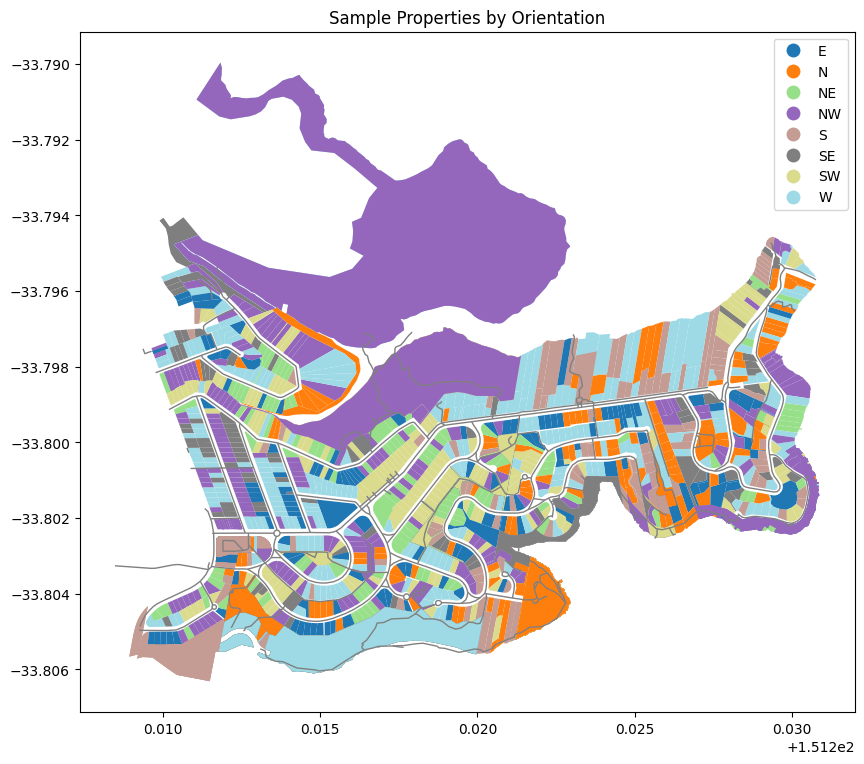

In [144]:
import matplotlib.pyplot as plt
sample = cadastre.sample(1473)
fig, ax = plt.subplots(figsize=(10, 10))
roads.plot(ax=ax, color='gray', linewidth=1)
sample.plot(ax=ax, column='orientation', cmap='tab20', legend=True, markersize=50)
plt.title("Sample Properties by Orientation")
plt.savefig("property_orientation_map.png")
plt.show()
